## Group Level Analysis

In [15]:
import os
os.chdir("/Users/giuseppe/Documents/Projects/RL_sim/")
from agents.utils import create_bins, discretize_observation
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import json
import ast

def read_json_log(log):
    with open(log, "rb") as f:
        log = json.load(f)
    return log
    
def json_array_to_list(arr):
    return ast.literal_eval(arr)


def score_datapoints(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return np.abs(arr - mu) < sigma

def calculate_snr(log):
    if isinstance(log, str):
        log = read_json_log(log)
    reward = np.array(json_array_to_list(log[-1]["reward"]))
    return reward.mean() / reward.std()

def pad_to_max_length(arr, max_length):
    return np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=0)

def plot_reward(logs):
    reward_log = []
    convergence_log = []
    SNRs = []
    sizes = []

    for log in logs:
        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])
        sizes.append(len(reward))

    max_length = np.max(sizes)
    min_length = np.min(sizes)

    for log in logs:
        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])
        convergence = json_array_to_list(log[-1]["convergence"])
        SNRs.append(np.float16(calculate_snr(log)))
        
        if len(reward_log) == 0:
            reward_log = pad_to_max_length(reward, max_length)
            convergence_log = pad_to_max_length(convergence, max_length)
        else:
            reward_log = np.vstack((reward_log, pad_to_max_length(reward, max_length)))
            convergence_log = np.vstack((convergence_log, pad_to_max_length(convergence, max_length)))

    snr = np.mean(SNRs)
    df = pd.DataFrame(columns=["trial", "reward", "convergence"])
    df["trial"] = np.arange(min_length)
    df["reward"] = np.mean(reward_log[:, :min_length], axis=0)
    df["convergence"] = np.mean(convergence_log[:, :min_length], axis=0)

    df = df[score_datapoints(df["reward"])]
    plt.figure(figsize=(10, 4))
    sns.regplot(x="trial", y="reward", data=df)
    plt.xlabel("Trials", fontsize=16)
    plt.ylabel("Reward", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"SNR: {snr}, Kernel Sigma: 4.0", fontsize=20)

    plt.figure(figsize=(10, 4))
    sns.regplot(x="trial", y="convergence", data=df)
    plt.xlabel("Trials", fontsize=16)
    plt.ylabel("Convergence", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def get_q_table_max(log, table_size):
    maxima = []
    for table in log:
        q_table = json_array_to_list(table["q_table"])
        maxima.append(np.unravel_index(np.argmax(q_table), table_size))
    return maxima

def get_q_table_steps(log, num_bins):
    steps = []
    for data in log:
        contrast = data["contrast"]
        frequency = data["frequency"]
        bins = create_bins(num_bins)
        steps.append(discretize_observation([contrast, frequency], bins))
    return steps

def plot_q_table_steps(logs):
    tables = []
    x_step_log = []
    y_step_log = []
    x_max_log = []
    y_max_log = []
    sizes = []

    for log in logs:
        log = read_json_log(log)
        sizes.append(len(log))

    max_length = np.max(sizes)
    min_length = np.min(sizes)

    for log in logs:
        log = read_json_log(log)
        step = np.array(get_q_table_steps(log, 10))
        cur_max = np.array(get_q_table_max(log, (10, 10))) # adjust discretization;

        if len(tables) == 0:
            tables = np.array(json_array_to_list(log[-1]["q_table"])).flatten()
            
            x_step_log = pad_to_max_length(np.array(step[:, 0]), max_length)
            y_step_log = pad_to_max_length(np.array(step[:, 1]), max_length)
            
            x_max_log = pad_to_max_length(cur_max[:, 0], max_length)
            y_max_log = pad_to_max_length(cur_max[:, 1], max_length) 
        else:
            tables = np.vstack((tables, np.array(json_array_to_list(log[-1]["q_table"])).flatten()))
            
            x_step_log = np.vstack((x_step_log, pad_to_max_length(step[:, 0], max_length)))
            y_step_log = np.vstack((y_step_log, pad_to_max_length(step[:, 1], max_length)))
            
            x_max_log = np.vstack((x_max_log, pad_to_max_length(cur_max[:, 0], max_length)))
            y_max_log = np.vstack((y_max_log, pad_to_max_length(cur_max[:, 1], max_length)))

    last_table = np.mean(tables, axis=0).reshape(10, 10)
    maxima = np.vstack([np.mean(x_max_log, axis=0), np.mean(y_max_log, axis=0)]).reshape(-1, 2).astype(int)
    steps = np.random.randint(0, len(maxima), len(maxima))

    plt.imshow(last_table)
    plt.xlabel("Frequency", fontsize=16)
    plt.ylabel("Contrast", fontsize=16)
    plt.colorbar().set_label("Q-value", fontsize=16)
    plt.plot(maxima[:, 1], maxima[:, 0], "--", alpha=0.4)
    plt.scatter(maxima[:, 1], maxima[:, 0], c=steps, cmap='plasma', alpha=0.5)
    plt.colorbar().set_label("Trial number", fontsize=16)
    plt.title(f"Real-time fMRI", fontsize=20)
    plt.show()


### Plot mean reward and convergence (all runs)

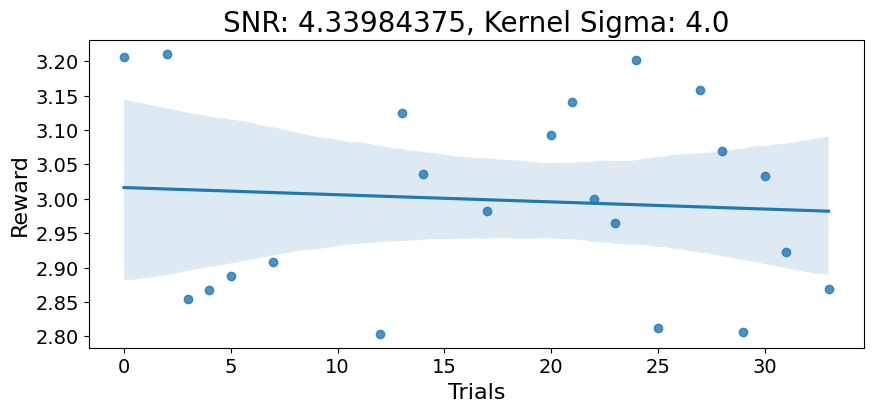

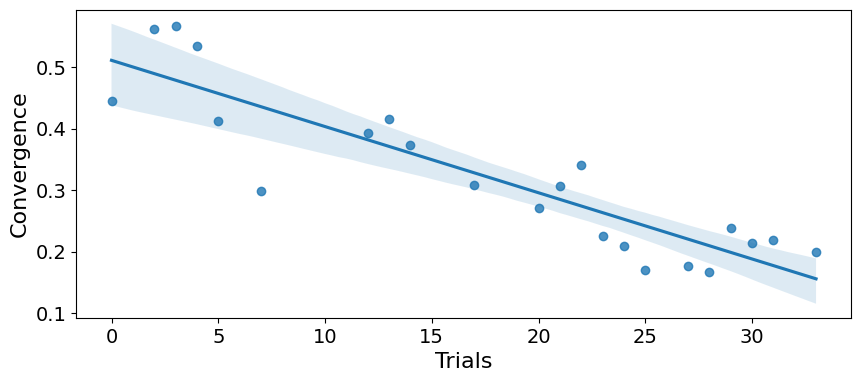

In [4]:
# plot reward;
subjects = ["sub-001", "sub-002", "sub-003"]
datapoints = ["data_1", "data_2"]
logs = [f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/{data}/log/log.json" for sub in subjects for data in datapoints]

plot_reward(logs)

### Plot mean Q-table

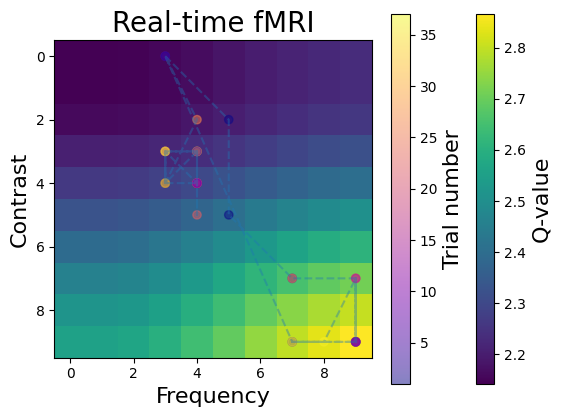

In [16]:
subjects = ["sub-001", "sub-002", "sub-003"]
datapoints = ["data_1", "data_2"]
logs = [f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/{data}/log/log.json" for sub in subjects for data in datapoints]

plot_q_table_steps(logs)

### Plot relationship between paradigm space and reward

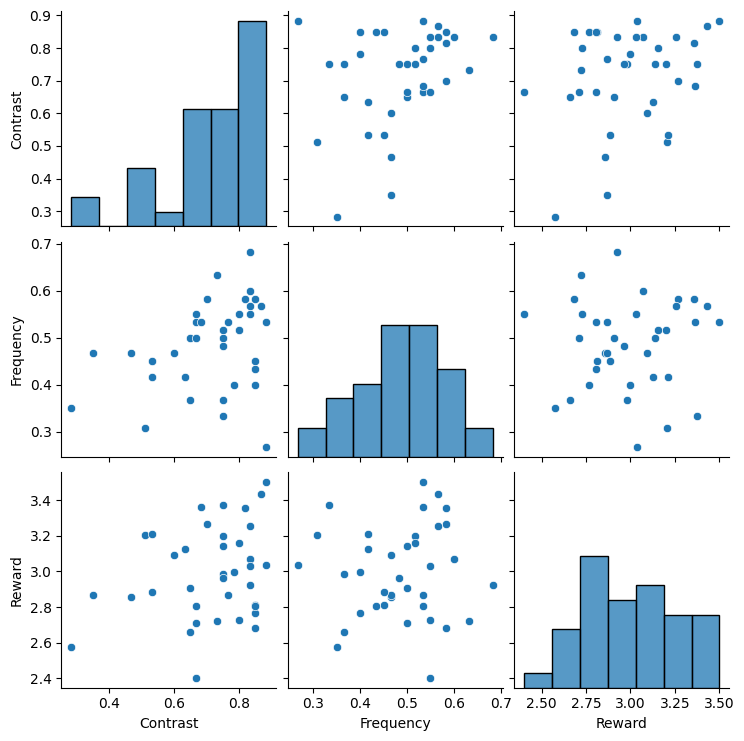

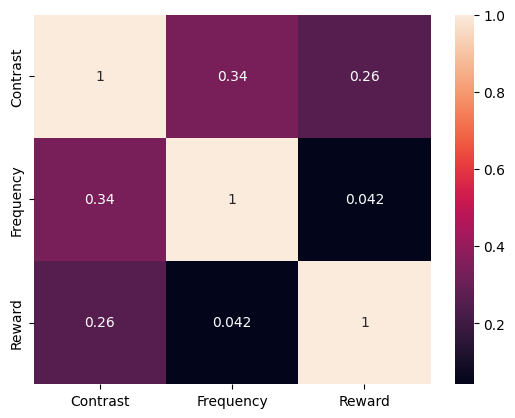

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_pspace(logs):
    
    contrast_log = []
    frequency_log = []
    reward_log = []
    sizes = []

    for log in logs:
        log = read_json_log(log)
        sizes.append(len(log))

    max_length = np.max(sizes)
    min_length = np.min(sizes)

    for log in logs:
        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])

        contrast = []
        frequency = []

        for idx in range(len(log)):
            if idx > 0:
                contrast.append(json_array_to_list(log[idx]["last action"])[0])
                frequency.append(json_array_to_list(log[idx]["last action"])[1])

        if len(contrast_log) == 0:
            contrast_log = pad_to_max_length(contrast, max_length)
            frequency_log = pad_to_max_length(frequency, max_length)
        else:
            contrast_log = np.vstack((contrast_log, pad_to_max_length(contrast, max_length)))
            frequency_log = np.vstack((frequency_log, pad_to_max_length(frequency, max_length)))
        
        if len(reward_log) == 0:
            reward_log = np.array(pad_to_max_length(reward, max_length))
        else:
            reward_log = np.vstack((reward_log, pad_to_max_length(reward, max_length)))
    
    contrast = np.mean(contrast_log, axis=0)[:min_length]
    frequency = np.mean(frequency_log, axis=0)[:min_length]
    reward = np.mean(reward_log, axis=0)[:min_length]

    data = pd.DataFrame({
        'Contrast': contrast,
        'Frequency': frequency,
        'Reward': reward
    })

    # Pairplot to visualize relationships
    sns.pairplot(data)
    plt.show()

    # Correlation matrix
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix, annot=True)
    plt.show()


subjects = ["sub-001", "sub-002", "sub-003"]
datapoints = ["data_1", "data_2"]
logs = [f"/Users/giuseppe/Documents/Projects/RL_sim/data/{sub}/{data}/log/log.json" for sub in subjects for data in datapoints]

plot_pspace(logs)